<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/exercises/ex5/ex5_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5: LLM Prompting and Prompt Engineering Part 1

In part 1, we experiment with advanced prompt engineering and parameter-efficient finetuning of Large Language Models (LLMs), and evaluate their performance on a toy task to assess their symbolic reasoning abilities.

The goal of this assignment is to gain some experience working with LLMs.
To this end, you will learn how to
- run inference at scale with base LLMs
- implement advanced prompting techniques
- finetune LLMs with LoRA adapters

The task we use for this purpose is a simple "Last Letter Concatenation" task presented in the original [Chain-of-Thought (CoT) prompting paper](https://arxiv.org/pdf/2201.11903).
For details on this task, we recommend reading Section 5 of the paper, which we've included below.

To facilitate working with LLMs, we will use the `Unsloth` library. Note that `Unsloth` provides both freeware and closed-source proprietary software. For our purposes, the freeware is sufficient!
For more information on Unsloth, see the docs [here](https://github.com/unslothai/unsloth).

This notebook is adapted from [this example](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing) by `Unsloth`.

### NOTE: Expected execution times
We have provided expected execution times throughout the notebook as a guide. These are intended to be approximate, but should give you some idea for what to expect. If your runtimes far exceed these expected execution times, you may want to consider modifying your approach. These are denoted with ⌛ .

### NOTE: GPU Usage
It is expected that you load the model onto a GPU for inference. For other parts of the code, such as data preparation, a GPU is not necessary. To avoid waiting for resources unnecessarily, we recommend doing as much as you can on a CPU instance and change the runtime type as necessary. We've highlight the cells that need a GPU with ⚡

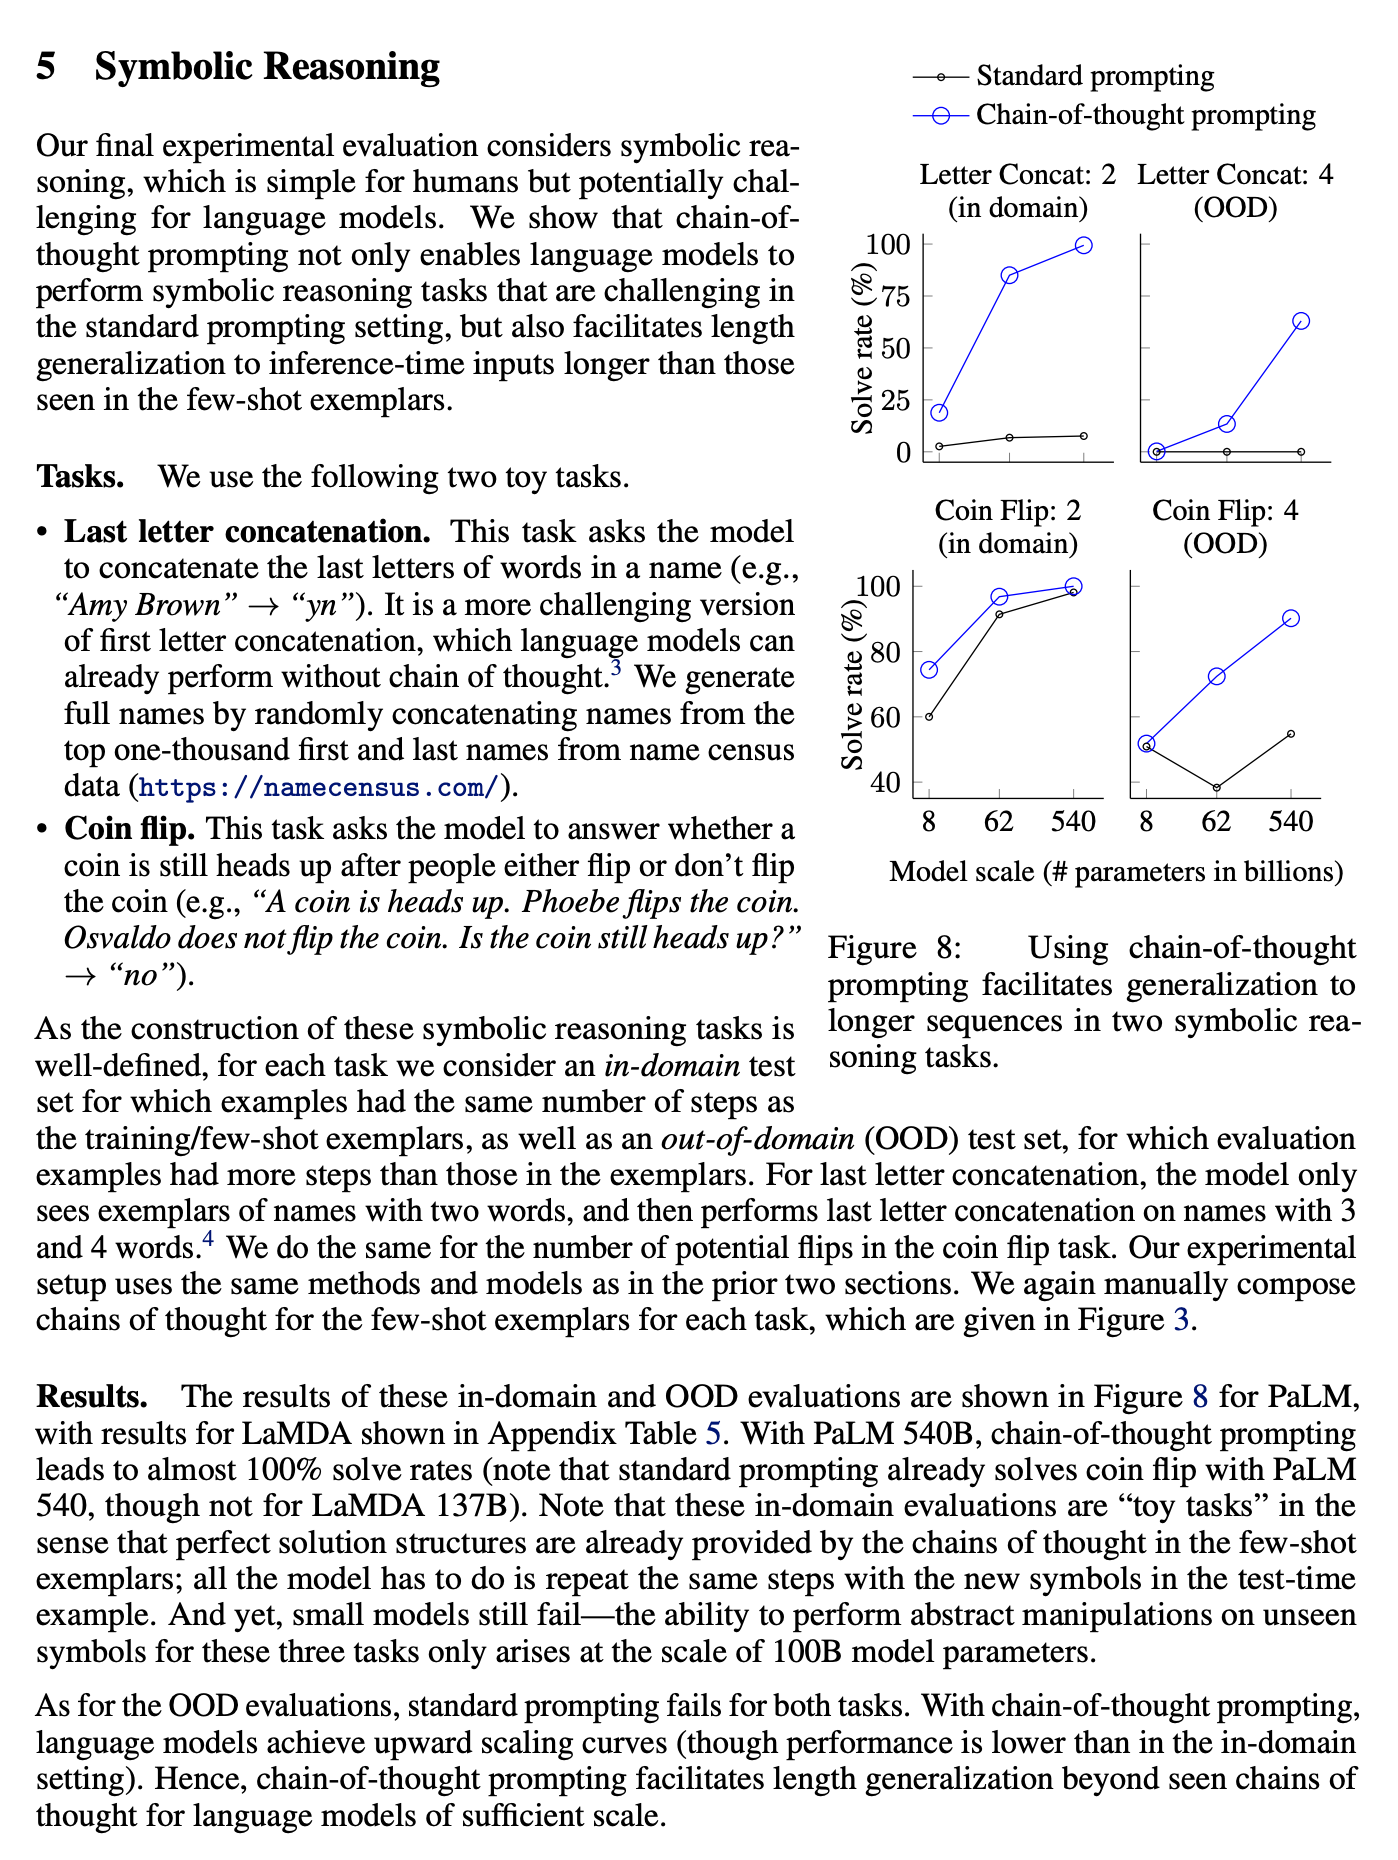

## 1) Installing dependencies

In [1]:
import pandas as pd
from tabulate import tabulate

In [2]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [3]:
# check unsloth version
expected_version = '2024.10.2'
unsloth_version = !pip list | grep -P 'unsloth\s+' | grep -Po '\S+$'
if unsloth_version[0] != expected_version:
    print(f"Warning! Found Unsloth version {unsloth_version[0]} but expected {expected_version}.")

# check python version
import sys
print(sys.version)

# check gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# check RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Warning! Found Unsloth version 2024.11.10 but expected 2024.10.2.
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Sun Dec  1 10:23:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                        

## 2) Loading a model for Inference

In [4]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# We're using an ungated version of Llama-3.2-3B that has already been optimized for 4bit inference by unsloth
model_name = "unsloth/Llama-3.2-3B-bnb-4bit"
# model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
    )

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Llam

## 3) Evaluation Helpers

In [5]:
# Here, we provide some boilerplate code for the evaluation of model-generated responses. You shouldn't need to make any changes here.

import re

def extract_answer(output):
    answer = re.search(r'Answer: (.*)', output)
    if answer:
        return answer.group(1)
    else:
        return None

def evaluate(targets, predictions):

    assert len(targets) == len(predictions), "Targets and predictions must have the same length"

    correct = 0
    for target, prediction in zip(targets, predictions):
        if target == prediction:
            correct += 1

    accuracy = correct / len(targets)
    return accuracy

## 4) Data Loading and Preparation

Use the code below to load the dataset and prepare it for our experiments.

In [6]:
# load data
import random
import pandas as pd

seed = 42

random.seed(seed)

dataset_url = "https://raw.githubusercontent.com/tannonk/prompting_exercise/refs/heads/main/data/names.csv"
df = pd.read_csv(dataset_url)

def prepare_data(df):
    # ID setting: last letters of first and last name
    df['t0'] = df.apply(lambda x: f'{x["first"][-1]}{x["last"][-1]}', axis=1)
    # OOD setting 1: last letters of first, middle, and last name
    df['t1'] = df.apply(lambda x: f'{x["first"][-1]}{x["middle"][-1]}{x["last"][-1]}', axis=1)
    return df

df = prepare_data(df)

test_data = df.sample(n=100, random_state=seed)
train_data = df.drop(test_data.index)

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

test_data.head()


Train data: 900
Test data: 100


first   middle    last  t0   t1
521     Scot   Dwight  Zavala  ta  tta
737    Andre   Marion  Gibson  en  enn
740  Annette  Jazmine  Berger  er  eer
660    River     Kory  Tucker  rr  ryr
411    Ryder      Ned   Horne  re  rde

### TODO: Inspect and Describe the Data

Take a moment to inspect and describe the dataset.

📝❓What columns are in the dataset and what values does each column have?

📝❓How many train and test instances do we have?

📝❓What do `t0` and `t1` represent?


## 5) Inference Pipeline


### TODO: Define a function to run inference efficiently with an LLM

In [7]:
# Set up our inference pipeline for generation

# First, we'll set some default generation args that we'll pass to our inference function below.
# For this, we'll follow best practices, and use a Pydantic class which helps with validation.
from pydantic import BaseModel

class Generation_Args(BaseModel):
    max_new_tokens: int
    temperature: float
    top_k: int
    top_p: float
    repetition_penalty: float
    do_sample: bool
    min_p: float
    num_return_sequences: int

# Here are some default generation args
generation_args = Generation_Args(
    max_new_tokens = 64,
    temperature = 1.0,
    top_k = 0,
    top_p = 1.0,
    repetition_penalty = 1.0,
    do_sample = True,
    use_cache = True,
    min_p = 0.1,
    num_return_sequences = 1
)


def run_batched_inference(prompts, model, tokenizer, batch_size=10, generation_args=generation_args):
    """
    Runs batched inference on a list of prompts using a given model and tokenizer.

    Set the batch_size to control the number of prompts processed in each batch.
    Depending on the length of your prompts and model size the batch size may need to be adjusted.

    Args:
        prompts (list[str]): List of prompts that are passed to the model
        model (): The model used for generation
        tokenizer (): The tokenizer used for encoding and decoding the prompts
        batch_size (int): Number of prompts to run batched inference on.

    Returns:
        List[str] containing generated outputs.
    """

    outputs = []

    # Process prompts in batches
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i + batch_size]

        # Tokenize the batch of prompts
        inputs = tokenizer(batch, padding=True, return_tensors="pt", truncation=True)

        # Move inputs to the same device as model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Generate outputs using the model
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                **generation_args.dict(),
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        # Decode the generated outputs
        decoded_outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)


        # Cleaning the outputs to start from the answer and remove the input prompt.
        # This is done to help the evaulation function which checks the first occurance of
        # "Answer: ".

        cleaned_outputs = []
        for prompt, output in zip(batch, decoded_outputs):
            # Extract the last input example from the prompt
            last_entry_start = prompt.rfind("\n\n")  # Find the last double newline
            if last_entry_start != -1:
                last_entry = prompt[last_entry_start:]  # Extract the last input example
                match_start = output.find(last_entry)  # Locate the last input in the output
                if match_start != -1:
                    # Start the cleaned output from the matched entry in the output
                    cleaned_output = output[match_start:]
                else:
                    cleaned_output = output

            else:
                cleaned_output = output

            cleaned_outputs.append(cleaned_output)


        outputs.extend(cleaned_outputs)

    return outputs

### TODO: Define the Methods to Create Your Prompts

Below, we've provided the definitation for `PromptTemplate` class. The class contains attributes for a task description and delimiters that can be used as part of the prompts if desired.

Within this class, define two new methods:

- `few_shot_prompt()`
- `training_prompt()`

Note, the few-shot prompt should be able to handle an any number of examples (i.e. 0 or more)! There is NO need to use any external libraries for this task.

Note, for more information on the format of the training prompt, see the description below.

In [8]:
class PromptTemplate:
    def __init__(self, task_description, bos=tokenizer.bos_token, eos="\n\n"):
        self.task_description = task_description
        self.bos = bos # Used for training prompt formatting
        self.eos = eos # Used for training prompt formatting

    def zero_shot_prompt(self, input_text):
        """
        Generates a zero-shot prompt with the input text.

        Args:
            input_text (str): The input text for which the model will generate an output.

        Returns:
            str: The formatted zero-shot prompt.
        """

        prompt = f"{self.task_description}\n\n{input_text}\nAnswer:"

        return prompt

    def few_shot_prompt(self, input_text, examples=[], affix="\nAnswer:"):
        """
        Generates a few-shot prompt with examples.

        Args:
            examples (list of dict): A list of dictionaries where each dict contains 'input' and 'output' keys.
            input_text (str): The new input text for which the model will generate an output.
            affix (str, optional): A string to be appended to the end of the prompt. Defaults to "\nAnswer:" (set to None for CoT prompting)
        Returns:
            str: The formatted few-shot prompt.
        """

        # TODO: write me
        # Start with task description
        prompt = f"{self.task_description}\n\n"

        # Add examples if provided
        for example in examples:
            prompt += f"{example['input']}\nAnswer: {example['output']}\n\n"


        prompt += "Now, perform the same thing for the following name: \n\n"

        # Add the new input
        prompt += f"{input_text}"

        # Add the affix if provided
        if affix is not None:
            prompt += affix

        return prompt


    def training_prompt(self, input_text, target=None):
        """
        Generates a simple seq-to-seq style prompt that can be used for finetuning a base model.

        Args:
            input_text (str): The input text to be used in the prompt.
            target (str, optional): The target text to be used in the prompt. Defaults to None.

        Returns:
            str: The formatted prompt.
        """

        # TODO: write me
        if target is None:
            return f"{self.bos}{input_text}{self.eos}"
        return f"{self.bos}{input_text}{self.eos}{target}{self.eos}"


## 6) Running Inference (Zero-Shot)

Now that we have a generation pipeline, let's start with assessing performance of the LLM on this task using zero-shot prompting!

⌛ 1-5 mins

⚡ GPU

In [9]:
# Initialise prompt template with basic instruction (can be the same for zero- and few-shot)
prompt_template = PromptTemplate("You will be given a person's full name. I want you to take the last character of their first name and concatenate it with the last character of their last name. Return this concatenated string.")

# Build our prompts that we'll pass to our `run_batched_inference` function.
prompts = []
for idx, row in test_data.iterrows():
    input_text = f"{row['first']} {row['last']}"
    prompt = prompt_template.zero_shot_prompt(input_text)
    prompts.append(prompt)

outputs = run_batched_inference(prompts, model, tokenizer)
answers = [extract_answer(output) for output in outputs]
accuracy = evaluate(test_data['t0'], answers)

info_df = pd.DataFrame([{'first_prompt': prompts[0],
                        'first_output': outputs[0],
                        'first_answer': answers[0],
                        'accuracy': f"Accuracy: {accuracy} on {len(test_data)} examples"}],
                       index=[0])

print(tabulate(info_df, headers='keys', tablefmt='psql'))

+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-------------------------------+
|    | first_prompt                                                                                                                                                                                      | first_output       | first_answer   | accuracy                      |
|----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-------------------------------|
|  0 | You will be given a person's full name. I want you to take the last character of their first name and concatenate it with the last character of their last name. Return this c

## 6.1) Running Inference (Few-shot)

The goal of few-shot prompting is to condition the LLM on the expected input and output format for the given task.

For example, if we wanted to use a base LLM for basic arithmetic, we might choose to provide `n` few-shot demonstrations as part of the prompt:

```
Answer the following arithmetic questions.

Q: What is 98 plus 45?
A: 143

Q: What is 5 minus 2?
A: 3

Q: What is 6 times 7?
A: 42

Q: What is 144 divided by 12?
A: 12

Q: What is 1024 times 4?
A:
```

Here, we `n`, the number of few-shot examples is 4. The final Q has no answer since this is the input query we want to perform inference on.


### TODO: Run inference using few-shot prompting with two values of `n` (e.g. 1, 8 and 20).

⌛ 3-15 mins

⚡ GPU

In [13]:
# TODO
n = [4, 8, 20] # 4 and 20 examples in the prompt

prompt_lists = {}

prompt_template = PromptTemplate("You will be given a person's full name. I want you to take the last character of their first name and concatenate it with the last character of their last name. Return this concatenated string. Some examples are as follows: ")

for n_value in n:
  prompts_for_curr_n = []
  for idx, row in test_data.iterrows():
      # For every test example, get the corresponding n train examples
      # The training samples are randomly selected
      examples = train_data.sample(n=n_value)

      example_list = []

      # Process n-shot examples
      for _, example in examples.iterrows():
          first = example['first']
          last = example['last']
          example_list.append({'input': first + " " + last, 'output': example['t0']})

      prompts_for_curr_n.append(prompt_template.few_shot_prompt(
          examples=example_list,
          input_text=row['first'] + " " + row['last']
          ))

  prompt_lists[n_value] = prompts_for_curr_n

outputs = {}
answers = {}
accuracies = {}

for n_val in n:
  outputs[n_val] = run_batched_inference(prompt_lists[n_val], model, tokenizer)
  answers[n_val] = [extract_answer(output) for output in outputs[n_val]]
  accuracies[n_val] = evaluate(test_data['t0'], answers[n_val])

for n_val in n:
  print(f"\n\n----------FOR N={n_val}-----------\n\n")
  prompts = prompt_lists[n_val]
  outputs_curr = outputs[n_val]
  answers_curr = answers[n_val]
  accuracy = accuracies[n_val]
  info_df = pd.DataFrame([{'first_prompt': prompts[0],
                        'first_output': outputs_curr[0],
                        'first_answer': answers_curr[0],
                        'accuracy': f"Accuracy: {accuracy} on {len(test_data)} examples"}],
                       index=[0])
  print(tabulate(info_df, headers='keys', tablefmt='psql'))



----------FOR N=4-----------


+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+----------------+--------------------------------+
|    | first_prompt                                                                                                                                                                                                                     | first_output                                                                                            | first_answer   | accuracy                       |
|----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 6.2) Running Inference with Chain-of-Thought Prompting

Now, we consider a more advanced prompting technique - Chain-of-Thought (CoT) prompting, as proposed by Wei et al. (2022).

### TODO: Using the function signature provided below, implement the logic to build CoT few-shot examples.

⌛ 1-5 mins

⚡ GPU

In [14]:
def letter_concatenation_cot(example):
    """
    Generates a CoT prompt for the letter concatenation task following Wei et al., 2022

    For example, given the input "Elon Musk", the resulting CoT is:

        'The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk."'

    Args:
    - example (dict): A dictionary containing 'input' and 'output' keys, e.g. {"input": "Elon Musk", "output": "nk"}
    """
    names = example['input'].split(" ")

    prompt = f"{names[0] + ' ' + names[1]}\nThe last letter of \"{names[0]}\" is \"{names[0][-1]}\". The last letter of \"{names[1]}\" is \"{names[1][-1]}\". Concatenating them is \"{example['output']}\". The answer is {example['output']}.\nAnswer: {example['output']}"

    return prompt

print(letter_concatenation_cot({"input": "Elon Musk", "output": "nk"}))

Elon Musk
The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk.
Answer: nk


In [16]:
# Keeping same n values for CoT prompting
n = [4, 8, 20]

prompt_lists = {}
outputs = {}
answers = {}
accuracies = {}

for n_value in n:
  prompts = []
  for idx, row in test_data.iterrows():
      # Get random examples from train data
      examples = train_data.sample(n=n_value)

      example_list = []

      for _, example in examples.iterrows():
          first = example['first']
          last = example['last']
          example_list.append({'input': first + " " + last, 'output': example['t0']})

      combined_prompt = ""
      for example in example_list:
          combined_prompt += letter_concatenation_cot(example) + "\n\n"

      combined_prompt += f"{row['first']} {row['last']}\n"

      prompts.append(combined_prompt)
  prompt_lists[n_value] = prompts

for n_val in n:
  outputs[n_val] = run_batched_inference(prompt_lists[n_val], model, tokenizer)
  answers[n_val] = [extract_answer(output) for output in outputs[n_val]]
  accuracies[n_val] = evaluate(test_data['t0'], answers[n_val])

for n_val in n:
  print(f"\n\n----------FOR N={n_val}-----------\n\n")
  prompts = prompt_lists[n_val]
  outputs_curr = outputs[n_val]
  answers_curr = answers[n_val]
  accuracy = accuracies[n_val]
  info_df = pd.DataFrame([{'first_prompt': prompts[0],
                        'first_output': outputs_curr[0],
                        'first_answer': answers_curr[0],
                        'accuracy': f"Accuracy: {accuracy} on {len(test_data)} examples"}],
                       index=[0])
  print(tabulate(info_df, headers='keys', tablefmt='psql'))




----------FOR N=4-----------


+----+--------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------+----------------+--------------------------------+
|    | first_prompt                                                                                                             | first_output                                                                                                        | first_answer   | accuracy                       |
|----+--------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------+----------------+--------------------------------|
|  0 | Wilbert Villegas                                                  

## 6.3) Running Inference (Out-of-domain test data)

So far, we've only considered the case where we provide few-shot or CoT examples with two-part names (i.e. first and last name).
Since our few-shot and CoT examples match the expected format used for evaluation, we can consider this to be an "in-domain" evaluation.

Let's see how the model performs in an "out-of-domain" setting.

### TODO: Evaluate the model's generalisation abilities to identify the last letters of three-part names (i.e. first + middle + last)

⌛ 1-5 mins

⚡ GPU

In [18]:
# TODO
n = [4, 8, 20] # 4 and 20 examples in the prompt

prompt_lists = {}

prompt_template = PromptTemplate("You will be given a person's full name. I want you to take the last character of their first name and concatenate it with the last character of their last name. Return this concatenated string. Some examples are as follows: ")

for n_value in n:
  prompts_for_curr_n = []
  for idx, row in test_data.iterrows():
      # For every test example, get the corresponding n train examples
      # The training samples are randomly selected
      examples = train_data.sample(n=n_value)

      example_list = []

      # Process n-shot examples
      for _, example in examples.iterrows():
          first = example['first']
          last = example['last']
          example_list.append({'input': first + " " + last, 'output': example['t0']})

      prompts_for_curr_n.append(prompt_template.few_shot_prompt(
          examples=example_list,
          input_text=row['first'] + " " + row['middle'] + " " + row['last']
          ))

  prompt_lists[n_value] = prompts_for_curr_n

outputs = {}
answers = {}
accuracies = {}

for n_val in n:
  outputs[n_val] = run_batched_inference(prompt_lists[n_val], model, tokenizer)
  answers[n_val] = [extract_answer(output) for output in outputs[n_val]]
  accuracies[n_val] = evaluate(test_data['t1'], answers[n_val])

for n_val in n:
  print(f"\n\n----------FOR N={n_val}-----------\n\n")
  prompts = prompt_lists[n_val]
  outputs_curr = outputs[n_val]
  answers_curr = answers[n_val]
  accuracy = accuracies[n_val]
  info_df = pd.DataFrame([{'first_prompt': prompts[0],
                        'first_output': outputs_curr[0],
                        'first_answer': answers_curr[0],
                        'accuracy': f"Accuracy: {accuracy} on {len(test_data)} examples"}],
                       index=[0])
  print(tabulate(info_df, headers='keys', tablefmt='psql'))



----------FOR N=4-----------


+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-------------------------------+
|    | first_prompt                                                                                                                                                                                                                     | first_output       | first_answer   | accuracy                      |
|----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-------------------------------|
|  0 | You will be given a person's full name. I want y

In [19]:
# Keeping same n values for CoT prompting
n = [4, 8, 20]

prompt_lists = {}
outputs = {}
answers = {}
accuracies = {}

for n_value in n:
  prompts = []
  for idx, row in test_data.iterrows():
      # Get random examples from train data
      examples = train_data.sample(n=n_value)

      example_list = []

      for _, example in examples.iterrows():
          first = example['first']
          last = example['last']
          example_list.append({'input': first + " " + last, 'output': example['t0']})

      combined_prompt = ""
      for example in example_list:
          combined_prompt += letter_concatenation_cot(example) + "\n\n"

      combined_prompt += f"{row['first']} {row['middle']} {row['last']}\n"

      prompts.append(combined_prompt)
  prompt_lists[n_value] = prompts

for n_val in n:
  outputs[n_val] = run_batched_inference(prompt_lists[n_val], model, tokenizer)
  answers[n_val] = [extract_answer(output) for output in outputs[n_val]]
  accuracies[n_val] = evaluate(test_data['t1'], answers[n_val])

for n_val in n:
  print(f"\n\n----------FOR N={n_val}-----------\n\n")
  prompts = prompt_lists[n_val]
  outputs_curr = outputs[n_val]
  answers_curr = answers[n_val]
  accuracy = accuracies[n_val]
  info_df = pd.DataFrame([{'first_prompt': prompts[0],
                        'first_output': outputs_curr[0],
                        'first_answer': answers_curr[0],
                        'accuracy': f"Accuracy: {accuracy} on {len(test_data)} examples"}],
                       index=[0])
  print(tabulate(info_df, headers='keys', tablefmt='psql'))




----------FOR N=4-----------


+----+-------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+--------------------------------+
|    | first_prompt                                                                                                            | first_output                                                                                                                                              | first_answer   | accuracy                       |
|----+-------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-------------

📝❓ For all settings test above (zero-, few- and CoT prompting both in-domain and out-of-domain), what is the impact of our prompt engineering efforts?

---

## 7) Task-specific Finetuning

So far we've experimented with different prompting strategies.

Let's see whether we can achieve better performance with a more classical transfer learning approach involving finetuning the pretrained model on the downstream task with supervised data.

Vanilla finetuning is a non-trivial task given the size of modern LLMs. Therefore, we will use Low-Rank Adapters (LoRA) [[Hu et al., 2021](https://arxiv.org/abs/2106.09685)].
LoRA is a parameter-efficient training approach which freezes the LLMs parameters and add much smaller, low-rank matrices of trainable weights, which are optimised during training.

As a result, the number of activate parameters and the amount of GPU memory is significantly reduced.

We can create a LoRA-adapted model by using the `get_peft_model` method. Here, we need to specify some hyperparameters.

Your task is to specify the `target_modules` (parts of the model) to apply `LoRA` to.

For more information on which these, see the docs [here](https://huggingface.co/docs/peft/v0.13.0/en/package_reference/lora).


📝❓Which `target_modules` can we apply `LoRA` to?


📝❓Given the `target_modules` specified, how many 'active' parameters does our model now have? I.e. how many parameters will be updated during training.

In [20]:
# For training, we will re-load a fresh model.
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Add LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.11.10 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


### TODO: Inspect the number of active parameters

In [21]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """

    trainable_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {trainable_count}')

print_trainable_parameters(model)

Total trainable parameters: 24313856


## 7.1) Preparing the Training Data

Because we are finetuning the base model, we are free to set the input/output format for our downstream task however we like.

To finetune a chat model, we typically want to have clear segmentation between the user's input query and the model's output response.

A basic template that satifies this might be:

`### Human: {user's input query}### Assistant: {model's output response}`

However, since our goal is not to train a general-purpose chat model, but rather a task-specific model, we can use something a bit more specific. For example:

`<|begin_of_text|>{task instruction}\n\n{input}\n\nAnswer: {output}\n\n`

Here, we recommend using `<|begin_of_text|>` and `\n\n` as delimiter tokens for this task.

### TODO: Prepare training data using the custom method you've defined in the `PromptTemplate` class.

Hint: we recommend loading the training and validation dataset as a `Huggingface` `Dataset` object, which can be pass directly to the trainer below.


In [22]:
prompts = []

for idx, row in train_data.iterrows():
    prompt = {
        'text': f'<|begin_of_text|>Take the last characters of the words and concatenate them.\n\n{row["first"] + " " + row["last"]}\n\nAnswer: {row["t0"]}\n\n'
    }
    prompts.append(prompt)

print(f'First prompt:\n\n{prompts[0]}')

# TODO: prepare training data

from datasets import Dataset # Huggingface Dataset

# convert list of dicts to Huggingface Dataset that we can pass to the trainer
dataset = Dataset.from_list(prompts)

# split daset into train and validation sets
dataset = dataset.train_test_split(test_size=0.1, seed=seed)
print(dataset)
print()
print(f'First prompt in training split:\n\n{dataset["train"][0]}')
print()
print(f'First prompt in validation split:\n\n{dataset["test"][0]}')

First prompt:

{'text': '<|begin_of_text|>Take the last characters of the words and concatenate them.\n\nPat Lloyd\n\nAnswer: td\n\n'}
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 810
    })
    test: Dataset({
        features: ['text'],
        num_rows: 90
    })
})

First prompt in training split:

{'text': '<|begin_of_text|>Take the last characters of the words and concatenate them.\n\nLea Bridges\n\nAnswer: as\n\n'}

First prompt in validation split:

{'text': '<|begin_of_text|>Take the last characters of the words and concatenate them.\n\nBeckham Romero\n\nAnswer: mo\n\n'}


## 7.2) Finetuning an LLM

For model finetuning, we've provided the basic call to `SFTTrainer` class from `Huggingface`.

You shouldn't need to change this.

In [23]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["test"],
    dataset_text_field = "text",
    max_seq_length = 256,
    # data_collator = DataCollatorForCompletionOnlyLM(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        eval_accumulation_steps = 4,
        evaluation_strategy = "steps",
        eval_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 2, # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to="none",
    ),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map (num_proc=2):   0%|          | 0/810 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/90 [00:00<?, ? examples/s]

In [24]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.605 GB of memory reserved.


⌛ 4-8 mins

⚡ GPU

In [25]:
# Run the training!
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 810 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 100
 "-____-"     Number of trainable parameters = 24,313,856


In [26]:
# Note, we can save the model adapters that we just trained as follows:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [27]:
# Note, we can reload it into memory as follows:
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

print(tokenizer.padding_side)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
left


### TODO: Run Inference with the finetuned model

Note, don't forget to use the same prompt template used during finetuning!

⌛ 1-5 mins

⚡ GPU

In [28]:
def extract_answer_ft(output):
    answer = re.findall(r'Answer: (.*)', output)
    if answer:
        return answer[1]
    else:
        return None

In [29]:
test_prompts = []
answers = []

for idx, row in test_data.iterrows():
    prompt = f'<|begin_of_text|>Take the last characters of the words and concatenate them.\n\n{row["first"] + " " + row["last"]}\n\nAnswer: \n\n'
    test_prompts.append(prompt)
    answers.append(row['t0'])

print(f'First prompt:{test_prompts[0]}')
print(f'First answer:{answers[0]}')

First prompt:<|begin_of_text|>Take the last characters of the words and concatenate them.

Scot Zavala

Answer: 


First answer:ta


In [31]:
outputs = run_batched_inference(test_prompts, model, tokenizer)
answers_ft = [extract_answer_ft(output) for output in outputs]
accuracy = evaluate(answers_ft, answers)

info_df = pd.DataFrame([{'first_prompt': test_prompts[0],
                      'first_output': outputs[0],
                      'first_answer': answers_ft[0],
                      'accuracy': f"Accuracy: {accuracy} on {len(test_data)} examples"}],
                      index=[0])
print(tabulate(info_df, headers='keys', tablefmt='psql'))

+----+------------------------------------------------------------------------------+----------------+----------------+--------------------------------+
|    | first_prompt                                                                 | first_output   | first_answer   | accuracy                       |
|----+------------------------------------------------------------------------------+----------------+----------------+--------------------------------|
|  0 | <|begin_of_text|>Take the last characters of the words and concatenate them. | Scot Zavala    | ta             | Accuracy: 0.81 on 100 examples |
|    |                                                                              |                |                |                                |
|    | Scot Zavala                                                                  | Answer:        |                |                                |
|    |                                                                            

📝❓ How does the performance of the finetuned model compare to the chain-of-thought prompting strategy?

📝❓ What are the pros and cons of a strategy like chain-of-thought prompting vs. finetuning an LLM on a downstream task?



### TODO: Run Inference with the finetuned model on out-of-domain data

Similar to how we evaluated the base LLM on an out-of-domain setting, let's evaluate the finetuned model on out-of-domain data too.

⌛ 1-5 mins

⚡ GPU

In [33]:
# TODO: test the finetuned model on OOD (first middle last)
test_prompts = []
answers = []

for idx, row in test_data.iterrows():
    prompt = f'<|begin_of_text|>Take the last characters of the words and concatenate them.\n\n{row["first"] + " " + row["middle"] + " " + row["last"]}\n\nAnswer: \n\n'
    test_prompts.append(prompt)
    answers.append(row['t1'])

print(f'First prompt:{test_prompts[0]}')
print(f'First answer:{answers[0]}')

First prompt:<|begin_of_text|>Take the last characters of the words and concatenate them.

Scot Dwight Zavala

Answer: 


First answer:tta


In [34]:
outputs = run_batched_inference(test_prompts, model, tokenizer)
answers_ft = [extract_answer_ft(output) for output in outputs]
accuracy = evaluate(answers_ft, answers)

info_df = pd.DataFrame([{'first_prompt': test_prompts[0],
                      'first_output': outputs[0],
                      'first_answer': answers_ft[0],
                      'accuracy': f"Accuracy: {accuracy} on {len(test_data)} examples"}],
                      index=[0])
print(tabulate(info_df, headers='keys', tablefmt='psql'))

+----+------------------------------------------------------------------------------+--------------------+----------------+-------------------------------+
|    | first_prompt                                                                 | first_output       | first_answer   | accuracy                      |
|----+------------------------------------------------------------------------------+--------------------+----------------+-------------------------------|
|  0 | <|begin_of_text|>Take the last characters of the words and concatenate them. | Scot Dwight Zavala | at             | Accuracy: 0.0 on 100 examples |
|    |                                                                              |                    |                |                               |
|    | Scot Dwight Zavala                                                           | Answer:            |                |                               |
|    |                                                          

---
## 8) Lab report

📝❓ Reflect on how your results with CoT prompting agree or disagree with the findings reported in Section 5 of the paper by Wei et al., 2022 (you can see the paper snippet at the at the top of this notebook or read the full article [here](https://arxiv.org/pdf/2201.11903)). Discuss potential reasons for any discrepencies.

📝❓ Write your lab report here addressing all questions in the notebook

# Lab Report

## Introduction
Large Language Models (LLMs) can be adapted to specific tasks through various prompting strategies or fine-tuning. This study examines these approaches on a simple character extraction task: concatenating the last characters of names.

## Methodology

### Task Description
- **In-domain**: Extract and concatenate last characters from first and last names
- **Out-of-domain**: Extract and concatenate last characters from first, middle, and last names

### Model & Data
- **Model**: Llama 3.2B (4-bit quantized)
- **Dataset**: Names dataset with 900 training examples and 100 test examples
- **Evaluation**: Exact match accuracy

### Approaches Tested
1. Zero-shot prompting
2. Few-shot prompting (n=4,8,20)
3. Chain-of-thought prompting (n=4,8,20)
4. LoRA fine-tuning

## Results

### In-Domain Performance

| Method | Examples (n) | Accuracy |
|--------|-------------|----------|
| Zero-shot | 0 | 0.0 |
| Few-shot | 4 | 0.02 |
| Few-shot | 8 | 0.02 |
| Few-shot | 20 | 0.02 |
| CoT | 4 | 0.52 |
| CoT | 8 | 0.54 |
| CoT | 20 | 0.49 |
| Fine-tuned | N/A | 0.81 |

### Out-of-Domain Performance

| Method | Examples (n) | Accuracy |
|--------|-------------|----------|
| Few-shot | 4 | 0.00 |
| Few-shot | 8 | 0.00 |
| Few-shot | 20 | 0.00 |
| CoT | 4 | 0.13 |
| CoT | 8 | 0.05 |
| CoT | 20 | 0.13 |
| Fine-tuned | N/A | 0.00 |

## Discussion

### Comparison with Wei et al. (2022)
The results partially align with Wei et al.'s findings regarding CoT prompting:
- CoT consistently outperformed standard few-shot prompting
- Increasing the number of examples (mostly) improved performance
- However, the performance gains were more modest than reported in the original paper

### Key Findings
1. **Prompting Strategy Impact**:
   - CoT prompting provided consistent improvements over basic few-shot prompting
   - Larger numbers of examples (n=20) yielded (in most cases) better results across all prompting methods. Some outliers like CoT were present where n=20 yielded worse results compared to n=4 and n=8. 

2. **Fine-tuning vs Prompting**:
   - Fine-tuning achieved the best performance for in-domain tasks but faltered on OOD tasks. 

3. **Out-of-Domain Generalization**:
   - All methods showed significant performance degradation on out-of-domain data
   - CoT was able to generalise better in OOD tasks. 

### Advantages and Limitations

**Chain-of-Thought Prompting**:
- Pros:
  - No training required
  - Flexible and easily modifiable
  - Transparent reasoning process
- Cons:
  - Requires careful prompt engineering
  - Higher inference costs
  - Lower performance ceiling

**Fine-tuning**:
- Pros:
  - Best overall performance in ID task
  - Faster inference
  - More consistent outputs
- Cons:
  - Requires training data and compute resources
  - Less flexible to task modifications (like OOD task)
  - Risk of overfitting

## Conclusion
While fine-tuning achieved the best performance, CoT prompting proved to be a competitive alternative, especially when considering the trade-off between development effort and performance. The study demonstrates that both approaches have their merits, with the choice depending on specific use case requirements such as development time, computational resources, and performance needs.

# Answering given questions 



📝❓What columns are in the dataset and what values does each column have?

The columns in the dataset are `first`, `middle`, `last`, `t0`, `t1`. All coulmns have string type values where the first three are 3 parts of a person's name and the other two are the concatanations of their last letters.

📝❓How many train and test instances do we have?

There are 900 train instances and 100 test instances.

📝❓What do `t0` and `t1` represent?

`t0` represents the concatenation of the last letters of the corresponding person's first and last name.
`t1` represents the concatenation of the last letters of the corresponding person's first, middle and last names. 

📝❓ For all settings test above (zero-, few- and CoT prompting both in-domain and out-of-domain), what is the impact of our prompt engineering efforts?

Prompt engineering efforts throughout the notebook had a lot of impact on the results for various ID and OOD tasks. Altering prompts for few shot and zero shot examples fluctuated the accuracy of the results between 0.00 - 0.02. Hence, we settled on the final prompt which gave us the maximum accuracy. However, when prompted with CoT examples, the accuracy shot up to 0.49-0.54 (depending on the number of examples provided). 

Another notable difference that prompt engineering makes can be seen in OOD tasks where models need to generalise. Where strategies like zero shot and few shot failed miserably, CoT was able to generalise and still achieved a modest accuracy of 0.13.


📝❓Which `target_modules` can we apply `LoRA` to?

1. Attention modules:
`q_proj`: Query projection layer
`k_proj`: Key projection layer
`v_proj`: Value projection layer
`o_proj`: Output projection layer
2. MLP/Feed-forward modules:
`gate_proj`: Gate projection layer
`up_proj`: Upward projection layer
`down_proj`: Downward projection layer

📝❓Given the `target_modules` specified, how many 'active' parameters does our model now have? I.e. how many parameters will be updated during training.

The total parameters will be 24313856.

📝❓ How does the performance of the finetuned model compare to the chain-of-thought prompting strategy?

The finetuned model perfomed better compared to chain-of-thought prompting (0.54 vs 0.8). This can be because the model has seen examples specifically related to this task during its updated training phase. However, this also means that the finetuned model will be worse off in generalisation tasks. When asked OOD questions, the finetuned model performed worse than the CoT prompting strategy. This shows overfitting on the data and a lack of generalisation capabilities. 

📝❓ What are the pros and cons of a strategy like chain-of-thought prompting vs. finetuning an LLM on a downstream task?

### Chain-of-Thought Prompting
Pros:
- No training required - can be implemented immediately
- More flexible - prompts can be easily modified for different variations of the task
- Transparent reasoning process - you can see how the model arrives at its answer
- Better generalization to out-of-domain examples (as shown in the results)
- No additional model parameters or storage needed

Cons:
- Lower performance ceiling compared to finetuning (0.54 vs 0.81 accuracy)
- Higher inference costs due to longer prompts
- Requires careful prompt engineering
- Results can be inconsistent between runs
- Takes up more context window space due to examples

### Finetuning
Pros:
- Better performance on the specific task (0.81 accuracy)
- Faster inference since no examples needed in prompt
- More consistent outputs
- Can be more parameter efficient with LoRA
- Better for production deployment

Cons:
- Requires training data and compute resources
- Less flexible - need to retrain for task modifications
- Risk of overfitting (as seen in poor OOD performance)
- Additional model weights to store
- Training process can be complex to optimize

📝❓ Reflect on how your results with CoT prompting agree or disagree with the findings reported in Section 5 of the paper by Wei et al., 2022 (you can see the paper snippet at the at the top of this notebook or read the full article [here](https://arxiv.org/pdf/2201.11903)). Discuss potential reasons for any discrepencies.

### Key Agreements with Wei et al.
- CoT Superiority Over Standard Prompting
    - Our results showed CoT (0.49-0.54 accuracy) significantly outperformed standard few-shot prompting (0.02 accuracy). This aligns with Wei et al.'s core finding that CoT improves performance across tasks
- Example Count Impact
    - We saw improvements when increasing examples from 4 to 8 (0.52 to 0.54 accuracy). This matches their observation that more examples generally help

### Key Differences
- Magnitude of Improvement
    - Wei et al. reported dramatic improvements with CoT across many tasks. Our improvements, while significant, were more modest (0.02 → 0.54)
- Scaling with Examples
    - Wei et al. showed consistent improvements with more examples. Our results plateaued and slightly declined at n=20 (0.49 accuracy)

### Potential Reasons for Discrepancies
- Model Differences
    - We used a smaller model (Llama 3.2B) vs their larger PaLM model. Smaller models may benefit less from CoT due to limited reasoning capabilities
- Task Complexity
    - Our character extraction task is relatively simple compared to their arithmetic/commonsense tasks
    - Simpler tasks may have a lower ceiling for CoT improvements
- Prompt Engineering
    - Wei et al. likely had more optimized prompts given their research focus
    - Our prompts may have room for improvement
- Evaluation Metrics
    - We used exact match accuracy while they may have used different metrics
    - This could affect how improvements are measured and reported

The key takeaway is that while we validated CoT's core benefits, the magnitude of improvement appears dependent on model size, task complexity, and implementation details.